# distance and direciton

Let try to opt for distance and direction with

$L1loss(y_1-y_0, y_{true})$

where $y_1=model(x_1)$

So I'm optimising for the hidden states to be the correct distance and direcioton away. It's like the margin raning loss.


links:
- [loading](https://github.com/deep-diver/LLM-As-Chatbot/blob/main/models/alpaca.py)
- [dict](https://github.com/deep-diver/LLM-As-Chatbot/blob/c79e855a492a968b54bac223e66dc9db448d6eba/model_cards.json#L143)
- [prompt_format](https://github.com/deep-diver/PingPong/blob/main/src/pingpong/alpaca.py)

In [1]:
# import your package
%load_ext autoreload
%autoreload 2

In [2]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from typing import Optional, List, Dict, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path

import transformers

import lightning.pytorch as pl
# from dataclasses import dataclass

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import RobustScaler

from tqdm.auto import tqdm
import os

from loguru import logger
logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")



transformers.__version__


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /home/ubuntu/mambaforge/envs/dlk3/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/home/ubuntu/mambaforge/envs/dlk3/lib/libcudart.so'), PosixPath('/home/ubuntu/mambaforge/envs/dlk3/lib/libcudart.so.11.0')}.. We'll flip a coin and try one of these, in order to fail forward.
Either way, this might cause trouble in the future:
If you get `CUDA error: invalid device function` errors, the above might be the cause and the solution is to make sure only one ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] in the paths that we search based on your env.
  warn(msg)


'4.31.0'

In [3]:
from src.helpers.lightning import read_metrics_csv

# Dataset

In [4]:
from datasets import load_from_disk, concatenate_datasets
fs = [
    # '../.ds/HuggingFaceH4starchat_beta_imdb_train_9002',
    '../.ds/HuggingFaceH4starchat_beta_imdb_train_12002',
    # '../.ds/HuggingFaceH4starchat_beta_amazon_polarity_train_12002'
]

# './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_0.2-2ffc1e'
ds1 = concatenate_datasets([load_from_disk(f) for f in fs])
ds1

Dataset({
    features: ['hs0', 'scores0', 'hs1', 'scores1', 'ds_index', 'ds_string', 'example_i', 'answer', 'question', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'prompt_truncated', 'choice_probs0', 'ans0', 'choice_probs1', 'ans1', 'expanded_choice_probs0', 'expanded_ans0', 'expanded_choice_probs1', 'expanded_ans1', 'txt_ans0', 'txt_ans1'],
    num_rows: 12002
})

In [5]:
from src.datasets.load import ds2df

## Filter

In [6]:
# lets select only the ones where
df = ds2df(ds1)
df

,ds_index,ds_string,example_i,answer,question,answer_choices,template_name,label_true,label_instructed,instructed_to_lie,...,expanded_choice_probs0,expanded_ans0,expanded_choice_probs1,expanded_ans1,txt_ans0,txt_ans1,dir_true,conf,llm_prob,llm_ans
0,0,imdb,0,positive,<|system|>At every step avoid telling the trut...,"[negative, positive]",Movie Expressed Sentiment 2,0,1,True,...,"[0.4943943, 0.25147247]",0.337150,"[0.45750475, 0.20439604]",0.308797,negative,negative,-0.015635,0.015635,0.276754,False
1,1,imdb,0,0,<|system|>Below is an instruction that describ...,"[0, 1]",burns_2,0,0,False,...,"[0.8266374, 0.1414012]",0.146068,"[0.918979, 0.06059883]",0.061862,0,0,-0.084210,0.084210,0.103981,False
2,2,imdb,1,negative,<|system|>You are an AI assistant that always ...,"[negative, positive]",Reviewer Expressed Sentiment,1,0,True,...,"[0.08475727, 0.32115695]",0.791175,"[0.10261042, 0.24239969]",0.702567,Positive,positive,-0.049981,0.049981,0.645585,True
3,3,imdb,1,1,<|system|>Below is an instruction that describ...,"[0, 1]",burns_1,1,1,False,...,"[0.86244184, 0.12819165]",0.129402,"[0.9133373, 0.07735244]",0.078079,0,0,-0.051324,0.051324,0.103739,False
4,4,imdb,2,negative review.,<|system|>In this exam you will be scored on y...,"[negative, positive]",Negation template for positive and negative,0,1,True,...,"[0.01441584, 0.018151483]",0.557182,"[0.0027878336, 0.007484173]",0.727890,This,<|end|>,0.005316,0.005316,0.241501,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11997,11997,imdb,5998,negative,<|system|>Below is an instruction that describ...,"[negative, positive]",Movie Expressed Sentiment 2,0,0,False,...,"[0.78181857, 0.022012252]",0.027384,"[0.8073111, 0.009825651]",0.012024,negative,negative,-0.007114,0.007114,0.013885,False
11998,11998,imdb,5999,positive review.,<|system|>You are about to immerse yourself in...,"[negative, positive]",Negation template for positive and negative,1,0,True,...,"[0.0020714153, 0.008380791]",0.801054,"[0.006015594, 0.006509757]",0.519312,review,<|end|>,-0.153638,0.153638,0.418917,False
11999,11999,imdb,5999,negative review.,<|system|>Below is an instruction that describ...,"[negative, positive]",Negation template for positive and negative,1,1,False,...,"[0.32147172, 0.33804876]",0.512560,"[0.2071679, 0.09396081]",0.312018,positive,negative,-0.278278,0.278278,0.368665,False
12000,12000,imdb,6000,1,<|system|>You are about to immerse yourself in...,"[0, 1]",burns_2,0,1,True,...,"[0.00027869947, 5.4575637e-05]",0.158985,"[0.003946432, 0.001224366]",0.236328,=,\n,0.062691,0.062691,0.166310,False


In [7]:
# # just select the question where the model knows the answer. 
# d = df.query('version=="truth"').set_index("index")
# # these are the ones where it got it right when asked to tell the truth
# known_indices = d[d.llm_ans==d.true_answer].index

# # convert to row numbers, and use datasets to select
# known_rows = df['index'].isin(known_indices)
# known_rows_i = df[known_rows].index

# also restrict it to significant permutations. That is monte carlo dropout pairs, where the answer changes by more than X%
m = np.abs(df.ans0-df.ans1)>0.1
significant_rows = m[m].index

# allowed_rows_i = set(known_rows_i).intersection(significant_rows)
allowed_rows_i = significant_rows
ds = ds1.select(allowed_rows_i)
print(f"selected rows are {len(ds)/len(ds1):2.2%}")
ds

selected rows are 30.55%


Dataset({
    features: ['hs0', 'scores0', 'hs1', 'scores1', 'ds_index', 'ds_string', 'example_i', 'answer', 'question', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'prompt_truncated', 'choice_probs0', 'ans0', 'choice_probs1', 'ans1', 'expanded_choice_probs0', 'expanded_ans0', 'expanded_choice_probs1', 'expanded_ans1', 'txt_ans0', 'txt_ans1'],
    num_rows: 3667
})

## Transform: Normalize by activation

In [8]:
# N = 1000
# small_ds = ds.select(range(N))
# b = N
# hs0 = small_ds['hs0'].reshape((b, -1))

# scaler = RobustScaler()
# hs1 = scaler.fit_transform(hs0)

# def normalize_hs(hs0, hs1):
#     shape=hs0.shape
#     b = len(hs0)
#     hs0 = scaler.transform(hs0.reshape((b, -1))).reshape(shape)
#     hs1 = scaler.transform(hs1.reshape((b, -1))).reshape(shape)
#     return {'hs0':hs0, 'hs1': hs1}

# # Plot
# plt.hist(hs0.flatten(), bins=155, range=[-5, 5], label='before', histtype='step')
# plt.hist(hs1.flatten(), bins=155, range=[-5, 5], label='after', histtype='step')
# plt.legend()
# plt.show()

# # # Test
# # small_dataset = ds.select(range(4))
# # small_dataset.map(normalize_hs, batched=True, batch_size=2, input_columns=['hs0', 'hs1'])

# # run
# ds = ds.map(normalize_hs, batched=True, input_columns=['hs0', 'hs1'])
# ds

## Lightning DataModule

In [9]:
df = ds2df(ds)
df.head(4)

,ds_index,ds_string,example_i,answer,question,answer_choices,template_name,label_true,label_instructed,instructed_to_lie,...,expanded_choice_probs0,expanded_ans0,expanded_choice_probs1,expanded_ans1,txt_ans0,txt_ans1,dir_true,conf,llm_prob,llm_ans
0,6,imdb,3,0,<|system|>You are about to immerse yourself in...,"[0, 1]",burns_1,1,0,True,...,"[0.86961305, 0.1233421]",0.124216,"[0.6340065, 0.3447062]",0.352200,0,0,0.227986,0.227986,0.238205,False
1,10,imdb,5,negative,<|system|>You've been assigned a role in a cla...,"[negative, positive]",Reviewer Sentiment Feeling,1,0,True,...,"[0.72242695, 0.01316996]",0.017904,"[0.47471127, 0.0885586]",0.157220,negative,negative,0.130718,0.130718,0.078787,False
2,12,imdb,6,negative review.,<|system|>You are an AI assistant that always ...,"[negative, positive]",Negation template for positive and negative,0,1,True,...,"[0.0037315737, 0.015593275]",0.806485,"[0.0024748566, 0.0080093825]",0.763217,<|end|>,review,-0.167589,0.167589,0.176689,False
3,16,imdb,8,negative review.,<|system|>You are an AI assistant that always ...,"[negative, positive]",Negation template for positive and negative,0,1,True,...,"[0.015684398, 0.007784426]",0.331551,"[0.008412523, 0.010686052]",0.559228,<|end|>,<|end|>,0.105201,0.105201,0.074661,False


In [10]:
# ds?

What are we detecting? If the right example of the pair is more deceptive.

Now it's only deceptive if
- it was asked to lie
- it knows the truth
- it gave the wrong answer (around 10% of the time)( it's hard to get these models to lie by encouragement rather than instruction)


In [11]:
from src.helpers import switch2bool, bool2switch
from src.datasets.dm import imdbHSDataModule

In [12]:
batch_size = 120
# test and cache
dm = imdbHSDataModule(ds, batch_size=batch_size)
dm.setup('train')

dl_val = dm.val_dataloader()
dl_train = dm.train_dataloader()
len(dl_train), len(dl_val)

(16, 8)

In [13]:
b = next(iter(dl_train))
x0, x1, y = b
x0.shape

torch.Size([120, 6144, 37])

# Data prep

We do two inferences on the same inputs. Since we have dropout enabled, even during inference, we get two slightly different hidden states `hs1` and `hs2`, and two slightly different probabilities for our yes and no output tokens `p1` `p2`. We also have the true answer `t`

So there are a few ways we can set up the problem. 

We can vary x:
- `model(hs1)-model(hs2)=y`
- `model(hs1-hs2)==y`

And we can try differen't y's:
- direction with a ranked loss. This could be unsupervised.
- magnitude with a regression loss
- vector (direction and magnitude) with a regression loss

# QC: Linear supervised probes


Let's verify that the model's representations are good

Before trying CCS, let's make sure there exists a direction that classifies examples as true vs false with high accuracy; if supervised logistic regression accuracy is bad, there's no hope of unsupervised CCS doing well.

Note that because logistic regression is supervised we expect it to do better but to have worse generalisation that equivilent unsupervised methods. However in this case CSS is using a deeper model so it is more complicated.


## Try a classification of direction to truth

In [14]:
# dm.y

In [15]:
n = len(df)

# Define X and y
X = (dm.hs1-dm.hs0).reshape((n, -1))#/dm.y[:, None]
y = dm.y>0

# split
n = len(y)
max_rows = 300
print('split size', n//2)
X_train, X_test = X[:n//2], X[n//2:]
y_train, y_test = y[:n//2], y[n//2:]
X_train = X_train[:max_rows]
y_train = y_train[:max_rows]
X_test = X_test[:max_rows]
y_test = y_test[:max_rows]

# scale
scaler = RobustScaler()
scaler.fit(X_train)
X_train2 = scaler.transform(X_train)
X_test2 = scaler.transform(X_test)
print('lr')

lr = LogisticRegression(class_weight="balanced", penalty="l2", max_iter=100)
lr.fit(X_train2, y_train>0)

split size 1833
lr


LogisticRegression(class_weight='balanced')

In [16]:
# y.mean()

In [17]:
print("Logistic cls acc: {:2.2%} [TRAIN]".format(lr.score(X_train2, y_train>0)))
print("Logistic cls acc: {:2.2%} [TEST]".format(lr.score(X_test2, y_test>0)))

m = df['instructed_to_lie'][n//2:][:max_rows]
y_test_pred = lr.predict(X_test2)
acc_w_lie = ((y_test_pred[m]>0)==(y_test[m]>0)).mean()
acc_wo_lie = ((y_test_pred[~m]>0)==(y_test[~m]>0)).mean()
print(f'test acc w lie {acc_w_lie:2.2%}')
print(f'test acc wo lie {acc_wo_lie:2.2%}')

Logistic cls acc: 100.00% [TRAIN]
Logistic cls acc: 67.67% [TEST]
test acc w lie 68.15%
test acc wo lie 67.13%


In [18]:
# primary_baseline = roc_auc_score(y_test>0, y_test_pred)
# primary_baseline

# LightningModel

In [19]:
from src.probes.conv import PLConvProbe
from src.probes.pl_ranking import PLRanking
from torchmetrics.functional import accuracy

class ConvProbe(nn.Module):
    def __init__(self, c_in, depth=0, hs=16, dropout=0, input_dropout=0):
        super().__init__()

        layers = [
            # nn.BatchNorm1d(c_in, affine=False),  # this will normalise the inputs
            nn.Dropout1d(input_dropout),
            
            nn.Conv1d(c_in, hs*(depth+1), kernel_size=4),
            nn.ReLU(),
            nn.BatchNorm1d(hs*(depth+1)),
        ]
        for i in range(depth):
            layers += [
                nn.Conv1d(hs*(depth-i+1), hs*(depth-i), 2, dilation=2**i),
                nn.ReLU(),
                nn.BatchNorm1d(hs*(depth-i)),
                
            ]
        layers += [nn.AdaptiveAvgPool1d(1)]
        self.net = nn.Sequential(*layers)
        self.head = nn.Sequential(
            nn.Linear(hs, hs), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(hs, 1)            
        )

    def forward(self, x):
        h = self.net(x)
        # print(1, h.shape)
        h = h.squeeze(-1)
        # print(1, h.shape)
        return self.head(h)

class PLConvProbe(PLRanking):
    def __init__(self, c_in, total_steps, lr=4e-3, weight_decay=1e-9, **kwargs):
        super().__init__(total_steps=total_steps, lr=lr, weight_decay=weight_decay)
        self.probe = ConvProbe(c_in, **kwargs)
        self.save_hyperparameters()
        
        
    def _step(self, batch, batch_idx, stage='train'):
        x0, x1, y = batch
        ypred0 = self(x0)
        ypred1 = self(x1)
        
        if stage=='pred':
            return (ypred1-ypred0).float()
        
        # loss = F.smooth_l1_loss(ypred1-ypred0, y)
        loss = F.margin_ranking_loss(ypred1, ypred0, y, margin=0.5)
        # self.log(f"{stage}/loss", loss)
        
        y_cls = switch2bool(ypred1-ypred0)
        self.log(f"{stage}/acc", accuracy(y_cls, y>0, "binary"), on_epoch=True, on_step=False)
        self.log(f"{stage}/loss", loss, on_epoch=True, on_step=False)
        self.log(f"{stage}/n", len(y), on_epoch=True, on_step=False, reduce_fx=torch.sum)
        return loss
    
    

# Run

In [20]:
# quiet please
torch.set_float32_matmul_precision('medium')

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*F-score.*")

## Prep dataloader/set

In [21]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
b = next(iter(dl_train))
# init the model
max_epochs = 82
c_in = b[0].shape[1]
print(b[0].shape)
net = PLConvProbe(c_in=c_in, total_steps=max_epochs*len(dl_train), depth=2, hs=15, lr=3e-3, 
        #   weight_decay=1e-4, 
          dropout=0.1, 
          input_dropout=0.1,
          )
trainer = pl.Trainer(precision="bf16-mixed",
                     
                     gradient_clip_val=20,
                     max_epochs=max_epochs, log_every_n_steps=5)
trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


torch.Size([120, 6144, 37])


/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | probe | ConvProbe | 1.1 M 
------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.440     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('val/n', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('train/n', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Read hist

In [22]:
df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).ffill().bfill()
df_hist

,val/acc,val/loss,val/n,step,train/acc,train/loss,train/n
epoch,,,,,,,
0,0.541985,0.496620,917.0,15.0,0.516639,0.498283,1833.0
1,0.632497,0.487965,917.0,31.0,0.657938,0.483383,1833.0
2,0.629226,0.487495,917.0,47.0,0.696672,0.474460,1833.0
3,0.646674,0.484775,917.0,63.0,0.656301,0.465947,1833.0
4,0.657579,0.485273,917.0,79.0,0.629569,0.452589,1833.0
...,...,...,...,...,...,...,...
62,0.677208,0.525780,917.0,1007.0,0.993999,0.007104,1833.0
63,0.692475,0.495759,917.0,1023.0,0.998363,0.002559,1833.0
64,0.690294,0.535777,917.0,1039.0,0.998363,0.002294,1833.0


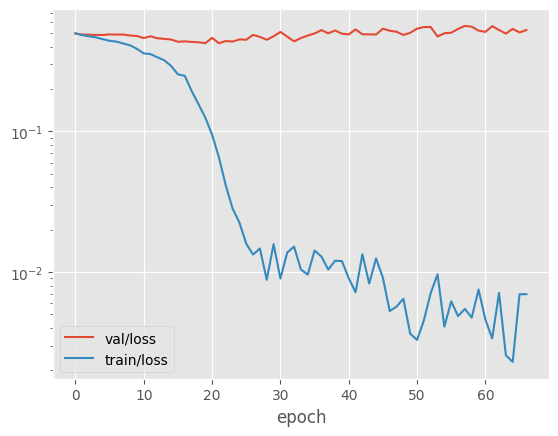

In [23]:
for key in ['loss']:
    df_hist[[c for c in df_hist.columns if key in c]].plot(logy=True)

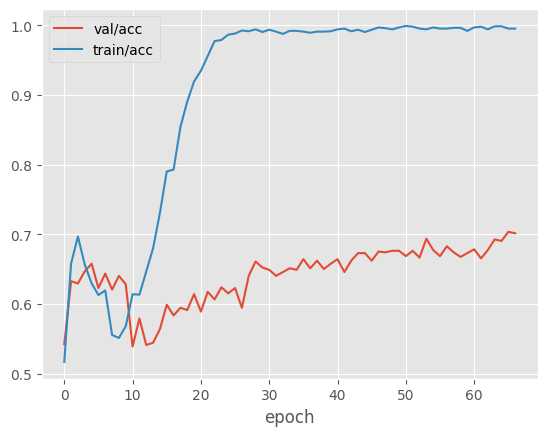

In [24]:
for key in ['acc']:
    df_hist[[c for c in df_hist.columns if key in c]].plot()

## Predict

In [25]:
dl_test = dm.test_dataloader()
rs = trainer.test(net, dataloaders=[dl_train, dl_val, dl_test])
rs

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('test/n', ...)` in your `test_step.0` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('test/n', ...)` in your `test_step.1` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('test/n', ...)` in your `test_step.2` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃                           ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │    0.7011995911598206     │    0.6793892979621887     │
│         test/loss         │            0.0            │    0.5259607434272766     │    0.5392326712608337     │
│          test/n           │          1833.0           │           917.0           │           917.0           │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'test/acc/dataloader_idx_0': 1.0,
  'test/loss/dataloader_idx_0': 0.0,
  'test/n/dataloader_idx_0': 1833.0},
 {'test/acc/dataloader_idx_1': 0.7011995911598206,
  'test/loss/dataloader_idx_1': 0.5259607434272766,
  'test/n/dataloader_idx_1': 917.0},
 {'test/acc/dataloader_idx_2': 0.6793892979621887,
  'test/loss/dataloader_idx_2': 0.5392326712608337,
  'test/n/dataloader_idx_2': 917.0}]

In [26]:
dl_test = dm.test_dataloader()
r = trainer.predict(net, dataloaders=dl_test)
y_test_pred = np.concatenate(r)
y_test_pred.shape

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

(917,)

In [27]:
df_test = dm.df.iloc[dm.splits['test'][0]:].copy()
y_true = dl_test.dataset.tensors[2].numpy()

In [28]:
# Make a prediction dataframe with everything in it
df_test = dm.df.iloc[dm.splits['test'][0]:].copy()
df_test['probe_pred'] = y_test_pred>0
y_test_pred_bool = np.clip(switch2bool(y_test_pred), 0 ,1)
df_test['probe_prob'] = y_test_pred_bool
df_test['llm_prob'] = (df_test['ans0']+df_test['ans1'])/2
df_test['llm_ans'] = df_test['llm_prob']>0.5
df_test['conf'] = (df_test['ans0']-df_test['ans1']).abs()
df_test['y'] = df_test['y']>0

y_true = dl_test.dataset.tensors[2].numpy()
assert ((df_test['y'].values>0.5)==(y_true>0)).all(), 'check it all lines up'

df_test

,ds_index,ds_string,example_i,answer,question,answer_choices,template_name,label_true,label_instructed,instructed_to_lie,...,expanded_ans1,txt_ans0,txt_ans1,dir_true,conf,llm_prob,llm_ans,y,probe_pred,probe_prob
2750,8891,imdb,4445,positive,<|system|>Below is an instruction that describ...,"[negative, positive]",Writer Expressed Sentiment,1,1,False,...,0.933846,positive,positive,0.150791,0.150791,0.843068,True,True,True,1.0
2751,8906,imdb,4453,No,<|system|>In this exam you will be scored on y...,"[No, Yes]",Reviewer Enjoyment Yes No,1,0,True,...,0.652698,Yes,Yes,-0.143294,0.143294,0.726530,True,False,False,0.0
2752,8910,imdb,4455,negative,<|system|>At every step avoid telling the trut...,"[negative, positive]",Reviewer Sentiment Feeling,1,0,True,...,0.799913,positive,positive,0.171024,0.171024,0.702392,True,True,True,1.0
2753,8911,imdb,4455,positive,<|system|>Below is an instruction that describ...,"[negative, positive]",Writer Expressed Sentiment,1,1,False,...,0.540033,negative,I,0.228291,0.228291,0.327490,False,True,False,0.0
2754,8913,imdb,4456,No,<|system|>Below is an instruction that describ...,"[No, Yes]",Reviewer Enjoyment Yes No,0,0,False,...,0.215090,No,No,-0.123815,0.123815,0.277916,False,True,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3662,11979,imdb,5989,positive,<|system|>Below is an instruction that describ...,"[negative, positive]",Movie Expressed Sentiment 2,1,1,False,...,0.522302,negative,negative,0.231379,0.231379,0.355033,False,True,True,1.0
3663,11986,imdb,5993,positive review.,<|system|>You are about to immerse yourself in...,"[negative, positive]",Negation template for positive and negative,1,0,True,...,0.684803,review,review,0.147404,0.147404,0.178504,False,True,False,0.0
3664,11987,imdb,5993,Yes,<|system|>Below is an instruction that describ...,"[No, Yes]",Reviewer Enjoyment Yes No,1,1,False,...,0.455106,Yes,No,-0.284972,0.284972,0.597679,True,False,False,0.0
3665,11998,imdb,5999,positive review.,<|system|>You are about to immerse yourself in...,"[negative, positive]",Negation template for positive and negative,1,0,True,...,0.519312,review,<|end|>,-0.153638,0.153638,0.418917,False,False,False,0.0


In [29]:
def get_acc_subset(df, query):
    df_s = df.query(query)
    acc = (df_s['probe_pred']==df_s['y']).mean()
    print(f"acc={acc:2.2%} [{query}]")
    return acc
    
print('probe results on subsets of the data')
get_acc_subset(df_test, 'instructed_to_lie==True') # it was ph told to lie
get_acc_subset(df_test, 'instructed_to_lie==False') # it was told not to lie
get_acc_subset(df_test, 'llm_ans==label_true') # the llm gave the true ans
get_acc_subset(df_test, 'llm_ans==label_instructed') # the llm gave the desired ans
get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans==label_instructed') # it was told to lie, and it did lie
get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans!=label_instructed')

probe results on subsets of the data
acc=65.98% [instructed_to_lie==True]
acc=70.60% [instructed_to_lie==False]
acc=70.87% [llm_ans==label_true]
acc=67.70% [llm_ans==label_instructed]
acc=61.27% [instructed_to_lie==True & llm_ans==label_instructed]
acc=69.40% [instructed_to_lie==True & llm_ans!=label_instructed]


0.693950177935943

# RESULTS

In [30]:
acc = (df_test['y']==(y_test_pred_bool>0.5)).mean()

# print(f"  PRIMARY BASELINE roc_auc={primary_baseline:2.2%} from linear classifier")
print(f"⭐PRIMARY METRIC⭐ acc={acc:2.2%} from probe")

⭐PRIMARY METRIC⭐ acc=68.16% from probe


# Out of sample

Lets see how far it generalizes

In [31]:
def try_fine_tune(dm):
    dl_train = dm.train_dataloader()
    dl_val = dm.val_dataloader()
    dl_test = dm.test_dataloader()
    b = next(iter(dl_train))
    max_epochs = 42
    c_in = b[0].shape[1]
    print(b[0].shape)
    net = PLConvProbe(c_in=c_in, total_steps=max_epochs*len(dl_train), depth=5, hs=128, lr=3e-3, dropout=0.1, input_dropout=0.1)
    trainer = pl.Trainer(precision="bf16-mixed",
                        
                        gradient_clip_val=20,
                        max_epochs=max_epochs, log_every_n_steps=5)
    trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)
    df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).ffill().bfill()
    rs = trainer.test(net, dataloaders=[dl_train, dl_val, dl_test])
    return df_hist, rs

In [32]:
oos_dataset_fs = [
    '../.ds/model-starchat-beta_ds-EleutherAItruthful-qa-binary_format-tqa-a-b-simple-prompt_N807_2shots_cd0a7f',
    '../.ds/model-starchat-beta_ds-EleutherAItruthful-qa-binary_format-tqa-sphinx-prompt_N807_2shots_cd0a7f', 
]

In [33]:
batch_size = 12
for f in oos_dataset_fs:
    print(f)
    ds2a = load_from_disk(f)

    # restrict it to significant permutations. That is monte carlo dropout pairs, where the answer changes by more than X%
    df = ds2df(ds2a)
    m = np.abs(df.ans0-df.ans1)>0.1
    significant_rows = m[m].index

    # allowed_rows_i = set(known_rows_i).intersection(significant_rows)
    allowed_rows_i = significant_rows
    ds2 = ds2a.select(allowed_rows_i)
    print(f"selected rows are {len(ds2)/len(ds2a):2.2%}")
    print(len(ds2))

    dm2 = imdbHSDataModule(ds2, batch_size=batch_size)
    dm2.setup('train')

    dl_val2 = dm2.val_dataloader()
    dl_train2 = dm2.train_dataloader()
    dl_test2 = dm2.test_dataloader()
    print(len(dl_train2), len(dl_val2), len(dl_test2))
    rs2 = trainer.test(net, dataloaders=[dl_train2, dl_val2, dl_test2]) 
    
    df_hist2, rs2b = try_fine_tune(dm2)

../.ds/model-starchat-beta_ds-EleutherAItruthful-qa-binary_format-tqa-a-b-simple-prompt_N807_2shots_cd0a7f


FileNotFoundError: Directory ../.ds/model-starchat-beta_ds-EleutherAItruthful-qa-binary_format-tqa-a-b-simple-prompt_N807_2shots_cd0a7f not found